In [1]:
import datetime
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid
from tqdm import tqdm


In [2]:

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [3]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)

!python --version

torch version :  2.2.2+cpu
torchvision version :  0.17.2+cpu
numpy version :  1.26.3
Python 3.11.4


### LOading Dataset

In [4]:
from pathlib import Path
import random

# Path to dataset folder
data_dir = Path("dataset")

# Load all .jpg images
image_list = list(data_dir.glob("*.jpg"))

print(f"Total images found: {len(image_list)}")

# Take random sample safely
sample_size = min(5, len(image_list))  # won't exceed dataset size
image_sample = random.sample(image_list, sample_size)

print("Random sample:", image_sample)



Total images found: 0
Random sample: []


In [5]:
import os
print("Current working directory:", os.getcwd())


Current working directory: d:\Projects\Medical_Images_Generation


In [6]:
image_list = list(data_dir.rglob("*.jpg"))
print(f"Total images found: {len(image_list)}")


Total images found: 412


This code will randomly select and display a few images. We have a collections of MRI scans of brains. 

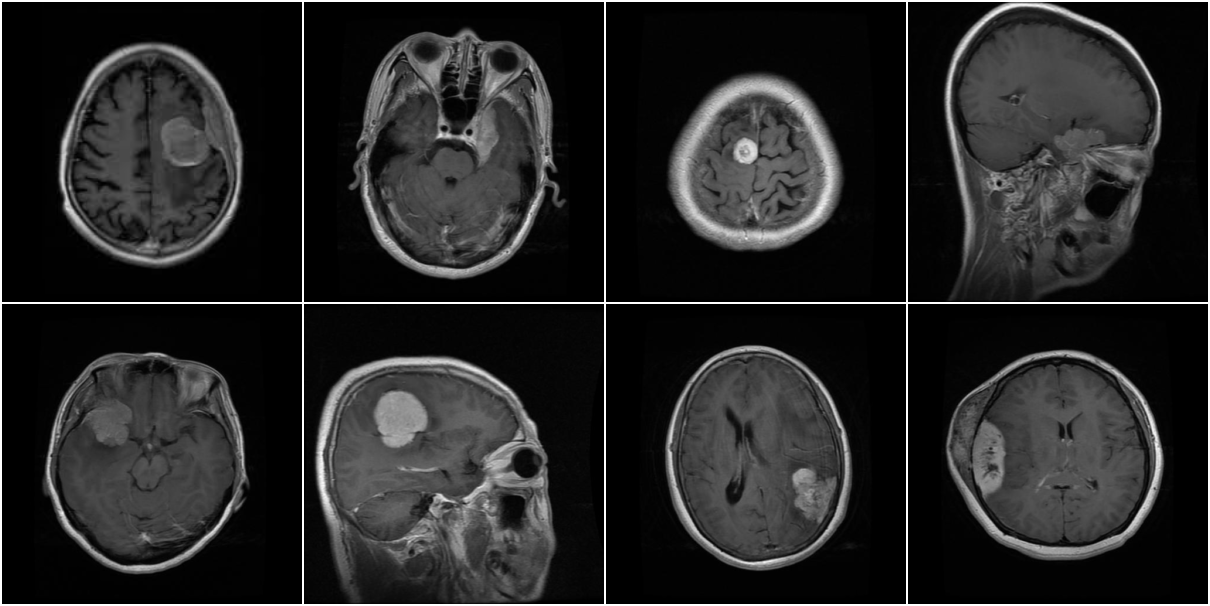

In [18]:
image_sample = random.sample(image_list, 8)

resize = transforms.Resize((300, 300))
gray = transforms.Grayscale()

images = []
for file in image_sample:
    img = read_image(str(file))
    img = gray(resize(img))
    images.append(img)

real_grid = make_grid(images, nrow=4, pad_value=255.0)
torchvision.transforms.ToPILImage()(real_grid)

Convert to grayscale

Resize to 64 x 64

Convert to tensor

The grayscale conversion reduces us to one color channel

In [19]:

IMAGE_SIZE = 64

transformations = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ]
)

transformations

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

Creating ImageFolder using our transformations, and a DataLoader. Using a batch size of 128.

In [20]:

batch_size = 128

dataset = datasets.ImageFolder(data_dir, transformations)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

single_batch = next(iter(dataloader))[0]
print(f"Batches have shape: {single_batch.shape}")

Batches have shape: torch.Size([128, 1, 64, 64])


## Generative Adversarial Networks

To work with generative adversarial networks (GANs), we generally need two networks. One is called the generator. It attempts to make new images. The second is the discriminator. It tries to tell if an image is real or created by the generator. The GAN process pits the two against each other.

### Discriminator

Our network will be:

Flatten image

Linear layer with 1024 neurons

LeakyReLU(0.25)

Linear layer with 512 neurons

LeakyReLU(0.25)

Linear Layer with 256 neurons

LeakyReLU(0.25)

Linear layer to produce one output (1 neuron)

Sigmoid

In [21]:

discriminator = nn.Sequential()
discriminator.append(nn.Flatten())

# Input images are 1 * 64 * 64 = 4096 pixels after flattening
discriminator.append(nn.Linear(1 * 64 * 64, 1024))
discriminator.append(nn.LeakyReLU(0.25))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.25)
)

In [22]:

discriminator(single_batch).shape

torch.Size([128, 1024])

Add the 512 neuron linear layer, LeakyReLU,256 linear layer,and LeakyReLU.
Make sure the negative_slope of the LeakyReLU layers have a 0.25 negative slope. If you make a mistake, you might need to recreate from scratch your discriminator model.

In [23]:

discriminator.append(nn.Linear(1024, 512))
discriminator.append(nn.LeakyReLU(0.25))
discriminator.append(nn.Linear(512, 256))
discriminator.append(nn.LeakyReLU(0.25))

discriminator

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.25)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.25)
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): LeakyReLU(negative_slope=0.25)
)

In [24]:
discriminator.append(nn.Linear(256, 1))

print("Getting results with following shape:")
print(discriminator(single_batch).shape)

Getting results with following shape:
torch.Size([128, 1])


linear layer with one output

In [25]:
print("Getting results with following shape:")
print(discriminator(single_batch).shape)

Getting results with following shape:
torch.Size([128, 1])


We want a value between 1 and 0. puting on the Sigmoid activation function

In [26]:

discriminator.append(nn.Sigmoid())

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=4096, out_features=1024, bias=True)
  (2): LeakyReLU(negative_slope=0.25)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.25)
  (5): Linear(in_features=512, out_features=256, bias=True)
  (6): LeakyReLU(negative_slope=0.25)
  (7): Linear(in_features=256, out_features=1, bias=True)
  (8): Sigmoid()
)

### Generator
The generator is a new structure for us. It will need to create new images out of nothing. How can we do this?

We'll start by creating some random numbers. We don't want to create the entire image randomly, since that would just give us noise. Instead, we'll create a smaller noise vector, basically an array of random numbers of some size. We'll pick 100 here, as a reasonable compromise size.

We'll then run a process similar to our discriminator in reverse. Instead of getting progressively smaller numbers of neurons per layer, we'll get progressively more, until we have the 4096 we need for a 1 x 64 x 64 image. We'll reshape that into an image, and output it.

In [27]:
noise_size = 100
first_stage_size = 256

generator = nn.Sequential()
generator.append(nn.Linear(noise_size, first_stage_size, bias=False))

# The batch norm doesn't change the shape, but needs the number of inputs
# The 0.8 adjusts its behavior, we'll use the same value for all stages
generator.append(nn.BatchNorm1d(first_stage_size, 0.8))
generator.append(nn.LeakyReLU(0.25))

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=False)
  (1): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.25)
)

This takes our 100 random numbers and gives us 256.

In [28]:
# Create a batch of random numbers
random_number_sample = torch.randn(batch_size, noise_size)
random_number_sample.shape

torch.Size([128, 100])

In [29]:

first_upscale = generator(random_number_sample)

print(f"After first upscale: {first_upscale.shape}")

After first upscale: torch.Size([128, 256])


Adding the second upsampling stage of a linear layer, BatchNorm1d, and LeakyReLU to the generator. we're setting bias=False in the Linear layer

In [30]:

second_stage_size = 512

# Add second upsampling stage
generator.append(nn.Linear(first_stage_size, second_stage_size, bias=False))
generator.append(nn.BatchNorm1d(second_stage_size, 0.8))
generator.append(nn.LeakyReLU(0.25))

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=False)
  (1): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.25)
  (3): Linear(in_features=256, out_features=512, bias=False)
  (4): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.25)
)

In [31]:
generator(random_number_sample).shape

torch.Size([128, 512])

Adding the third upsampling stage of a linear layer, BatchNorm1d, and LeakyReLU to the generator.we're setting bias=False in the Linear layer.

In [32]:
third_stage_size = 1024

# Add third upsampling stage
generator.append(nn.Linear(second_stage_size, third_stage_size, bias=False))
generator.append(nn.BatchNorm1d(third_stage_size, 0.8))
generator.append(nn.LeakyReLU(0.25))

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=False)
  (1): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.25)
  (3): Linear(in_features=256, out_features=512, bias=False)
  (4): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.25)
  (6): Linear(in_features=512, out_features=1024, bias=False)
  (7): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.25)
)

In [33]:

generator(random_number_sample).shape

torch.Size([128, 1024])

Our target output size is 4096.we'll do that in a single stage.

In [34]:
# Add the final linear layer
output_size = 1 * 64 * 64
generator.append(nn.Linear(third_stage_size, output_size, bias=False))

generator

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=False)
  (1): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.25)
  (3): Linear(in_features=256, out_features=512, bias=False)
  (4): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.25)
  (6): Linear(in_features=512, out_features=1024, bias=False)
  (7): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.25)
  (9): Linear(in_features=1024, out_features=4096, bias=False)
)

This will be our final stage, so we'll use a different activation function. We aren't restricted to a classification output like the discriminator was, but we need something that has image-like values. We could use the Sigmoid again, but instead we'll use the Tanh this time.
We'll also need to reshape our 4096 to an image. We'll use Unflatten here, the opposite of Flatten. It takes a single dimension and expands it to whatever shape we ask for. We'll tell it to take the second dimension of the tensor (the 4096 rather than the batch size) and expand it to a [1, 64, 64]. Recall that Python is zero-based indexing, so the second dimension is called 1.

In [35]:

generator.append(nn.Tanh())
generator.append(nn.Unflatten(1, [1, 64, 64]))

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=False)
  (1): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.25)
  (3): Linear(in_features=256, out_features=512, bias=False)
  (4): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.25)
  (6): Linear(in_features=512, out_features=1024, bias=False)
  (7): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.25)
  (9): Linear(in_features=1024, out_features=4096, bias=False)
  (10): Tanh()
  (11): Unflatten(dim=1, unflattened_size=[1, 64, 64])
)

In [36]:

generator_output = generator(random_number_sample) 
output_shape = generator_output.shape

print(f"Generator output shape: {output_shape}")

Generator output shape: torch.Size([128, 1, 64, 64])


Right now it's untrained, so it will create images that are just noise

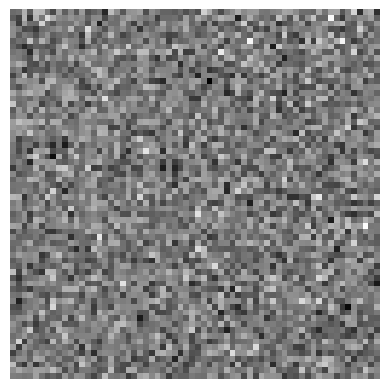

In [37]:

plt.imshow(generator_output[0, 0].detach(), cmap="gray")
plt.axis("off");

### Training the GAN System

Training will work a bit differently We aren't training a single network, but instead we're training two networks against each other. We can still use the same tools, but we'll need to organize things differently. We also don't have already labeled data, we'll have to mark our images as real or fake (we'll use the label 1 for real and 0 for fake).

In [38]:

# Gets the time in the order year-month-day_hour-minute-second
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
now

'2025-08-17_19-08-37'

In [39]:

runs_dir = Path("runs")
now_dir = runs_dir / now

# Create the directories with mkdir
now_dir.mkdir(parents=True, exist_ok=True)
print(f'directory "{now_dir}" exists: {now_dir.exists()}')

directory "runs\2025-08-17_19-08-37" exists: True


To train the models, we'll need optimizers. The discriminator and generator will need separate ones, since they're going to have different goals. We want the discriminator to get better at telling real from fake, and the generator to get better at fooling the discriminator. So an optimization step for one makes the other one worse!.we can use the same kind of optimizer for both, with the same settings. We'll use AdamW, a modified version of the Adam that we've been using. We'll also adjust two of its settings: lr and betas. We found that modifying these gave us better training results

In [40]:

lr = 0.0002
betas = (0.5, 0.999)

disc_opt = torch.optim.AdamW(params=discriminator.parameters(), lr=lr, betas=betas)
gen_opt = torch.optim.AdamW(params=generator.parameters(), lr=lr, betas=betas)

n_disc_pars = len(disc_opt.param_groups[0]["params"])
n_gen_pars = len(gen_opt.param_groups[0]["params"])

print(f"disc_opt sees {n_disc_pars} parameters, should be 8")
print(f"get_opt sees {n_gen_pars} parameters, should be 10")

disc_opt sees 8 parameters, should be 8
get_opt sees 10 parameters, should be 10


We'll also need a loss function. We'll use the same one for both, the BCELoss. This is the binary cross entropy, very similar to the cross entropy. The biggest differences are that this is only expecting one class, and that it expects predictions that have been run through the Sigmoid function. If we hadn't included the Sigmoid to get predictions between 0 and 1 we'd need the BCEWithLogitsLoss instead.

In [41]:

loss_function = nn.BCELoss()

In [42]:
# discriminator to device
discriminator.to(device)
# generator to device
generator.to(device)
disc_dev = next(generator.parameters()).device.type
gen_dev = next(generator.parameters()).device.type

print(f"Discriminator on {disc_dev}")
print(f"Generator on {gen_dev}")

Discriminator on cpu
Generator on cpu


### Generating Images

We're going to need to have the generator create images at each step in the training. It's important that these are new images, based on a new random number draw. If we used the same random number, the model would only ever be able to create one set of images! We want it to create an endless supply, that's the point. Since we'll be doing that a lot, let's make a function for it.

In [43]:

def make_random_images(batch_size, generator=generator):
    # Create a batch of random numbers
    random_number_sample = torch.randn(batch_size, 100)
    random_number_sample = random_number_sample.to(device)
    generator.eval()

    # Run the generator on the random numbers
    generator_output = generator(random_number_sample)

    return generator_output

In [44]:
# Test run
sample_images = make_random_images(batch_size, generator)
print(f"Output shape: {sample_images.shape}")

Output shape: torch.Size([128, 1, 64, 64])


We should be getting batches of images, with shape [128, 1, 64, 64] since we have batch_size of 128. They're noise right now, but we'll want to print a sample as we train to see how the model is improving. This function displays them on screen

In [45]:

def display_images(image_tensor, n_to_display=6):
    grid = make_grid(image_tensor[:n_to_display], nrow=6, normalize=True)
    img_out = transforms.ToPILImage()(grid)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(img_out)
    plt.axis("off")
    plt.show()

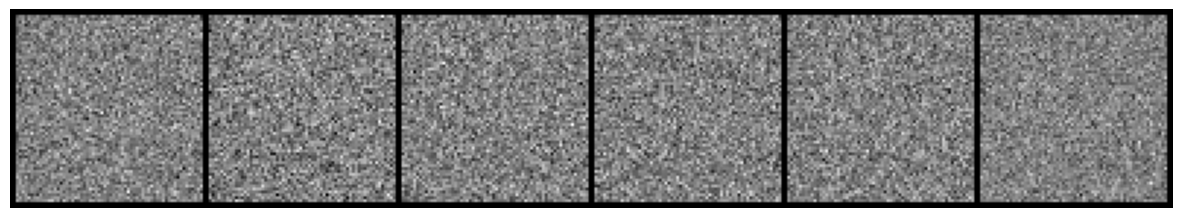

In [46]:

display_images(sample_images)

### Training Step
As usual, our training will be a number of epochs. Each epoch is one pass through the real data, broken into minibatches. So our training process will be a loop over epochs, and each of those loops is a loop over batches. Let's call the processing of one batch a batch step.

Each batch step in our training will follow this pattern:

Take a batch of real images, label them all

Train the discriminator one step on the real images

Have the generator create a batch of fake images, label them all 

Train the discriminator one step on the fake images

Get the predictions of the discriminator on the fake images

Train the generator to trick the discriminator

In [47]:
def perform_batch_step(
    discriminator,
    generator,
    real_data_batch,
    loss_function,
    disc_opt,
    gen_opt,
    device=device,
):
    """Perform a single batch step"""

    # Set real and fake labels
    real_label_val = 1.0
    fake_label_val = 0.0

    # Send real data to device
    # This pulls out just the images, we'll make our own label
    real_images = real_data_batch[0].to(device)

    # Create labels: all 1.0 for real data
    actual_batch_size = real_images.size(0)
    real_label = torch.full((actual_batch_size, 1), real_label_val, device=device)

    # Get the derivative for the real images
    disc_opt.zero_grad()
    real_output = discriminator(real_images)
    real_loss = loss_function(real_output, real_label)
    real_loss.backward()

    # Generate fake images using the generator
    fake_images = make_random_images(actual_batch_size, generator)
    # label all fake images as 0.0
    fake_label = torch.full((actual_batch_size, 1), fake_label_val, device=device)

    # Get the derivative for the fake images
    fake_output = discriminator(fake_images.detach())
    fake_loss = loss_function(fake_output, fake_label)
    fake_loss.backward()

    # Discriminator total loss
    disc_loss = real_loss.item() + fake_loss.item()

    # Train the discriminator
    disc_opt.step()

    # Get derivative for the generator
    # We're adjusting the generator to make the
    # discriminator think fake images are real
    gen_opt.zero_grad()
    trick_output = discriminator(fake_images)
    trick_loss = loss_function(trick_output, real_label)
    trick_loss.backward()

    # Train the generator
    gen_opt.step()

    # Generator loss
    gen_loss = trick_loss.item()

    # Return discriminator loss and generator loss for logging
    return gen_loss, disc_loss

we'll get the state dictionary of the discriminator and generator, and save them to files named discriminator_{epoch}.pth and generator_{epoch}.pth, respectively. This will give us a file for each epoch, which we can load if something goes wrong or when the training is done.

In [48]:
def save_models(discriminator, generator, epoch, directory):
    # Get discriminator state dictionary
    disc_state_dict = discriminator.state_dict()

    disc_filename = directory / f"discriminator_{epoch}.pth"

    # Save discriminator save dictionary to `disc_filename`
    torch.save(disc_state_dict, disc_filename)

    # Get generator state dictionary
    gen_state_dict = generator.state_dict()

    gen_filename = directory / f"generator_{epoch}.pth"

    # Save generator save dictionary to `gen_filename`
    torch.save(gen_state_dict, gen_filename)

In [49]:

save_models(discriminator, generator, "untrained", now_dir)

print(f"Files in {now_dir}")
for filename in now_dir.glob("*"):
    print("\t", filename)

Files in runs\2025-08-17_19-08-37
	 runs\2025-08-17_19-08-37\discriminator_untrained.pth
	 runs\2025-08-17_19-08-37\generator_untrained.pth


In [50]:
def train_epoch(
    discriminator,
    generator,
    real_image_loader,
    loss_function,
    disc_opt,
    gen_opt,
    epoch,
    device=device,
):
    # train the model
    total_disc_loss = 0
    total_gen_loss = 0
    for real_data_batch in tqdm(real_image_loader):
        disc_loss, gen_loss = perform_batch_step(
            discriminator,
            generator,
            real_data_batch,
            loss_function,
            disc_opt,
            gen_opt,
            device,
        )
        # Keep a running total of losses from each batch
        total_disc_loss += disc_loss
        total_gen_loss += gen_loss

    # Save the models at the current epoch
    save_models(discriminator, generator, epoch, now_dir)

    print(f"Epoch {epoch} finished")
    print(f"Discriminator loss: {disc_loss}, Generator loss: {gen_loss}")

    # Create 6 images
    sample_images = make_random_images(6, generator)

    # Display the images
    display_images(sample_images)

100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 0 finished
Discriminator loss: 0.6538612246513367, Generator loss: 1.0940234959125519


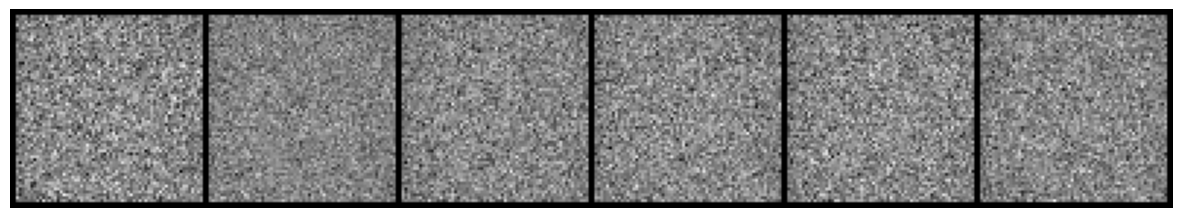

In [51]:
train_epoch(
    discriminator, generator, dataloader, loss_function, disc_opt, gen_opt, epoch=0
)

100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

Epoch 1 finished
Discriminator loss: 0.4976712763309479, Generator loss: 1.1504538357257843


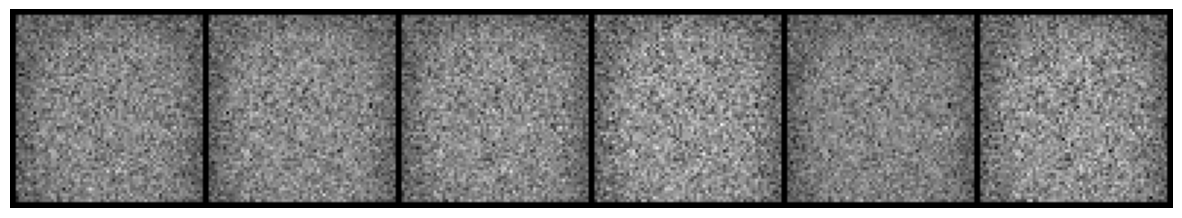

100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 2 finished
Discriminator loss: 0.695017397403717, Generator loss: 1.2711784839630127


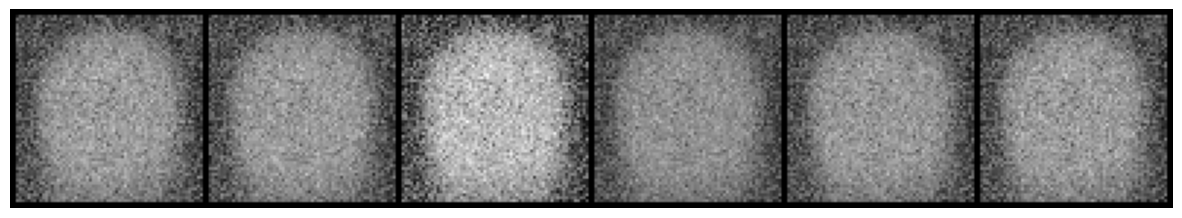

In [52]:

total_epochs = 3

for epoch in range(1, total_epochs):
    train_epoch(
        discriminator,
        generator,
        dataloader,
        loss_function,
        disc_opt,
        gen_opt,
        epoch=epoch,
    )

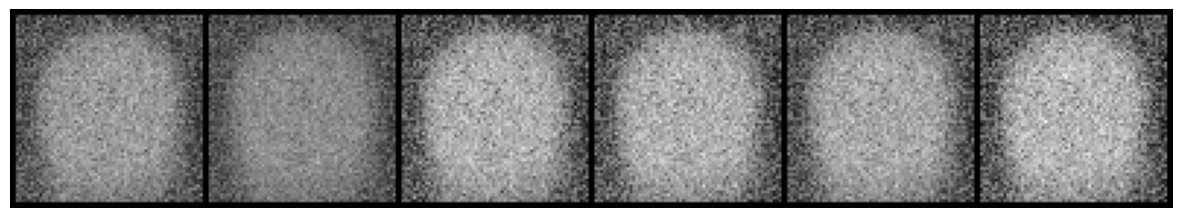

In [53]:

# Create 6 images
sample_images = make_random_images(6, generator)
    
# Display the images
display_images(sample_images)

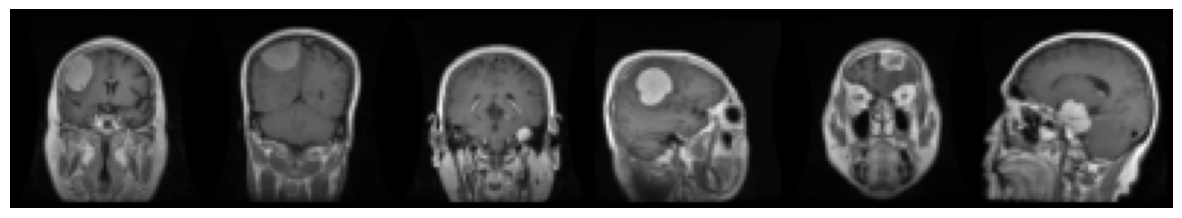

In [54]:

single_batch = next(iter(dataloader))[0]
display_images(single_batch)